### Setup

In [2]:
from __future__ import print_function
import random
import numpy as np
import time
from utils.data_utils import load_CIFAR10, get_CIFAR10_data
from utils.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from utils.solver import Solver
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [3]:
# let's download the data
%cd ../datasets

# 1 -- Linux 
# 2 -- MacOS
# 3 -- Command Prompt on Windows
# 4 -- manually downloading the data
choice = 3


if choice == 1:
    # should work well on Linux and in Powershell on Windows
    !wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
elif choice == 2 or choice ==3:
    # if wget is not available for you, try curl
    # should work well on MacOS
    !curl http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz --output cifar-10-python.tar.gz
else:
    print('Please manually download the data from http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz and put it under the datasets folder.')
!tar -xzvf cifar-10-python.tar.gz

if choice==3:
    !del cifar-10-python.tar.gz
else:
    !rm cifar-10-python.tar.gz

D:\CS7150\pa1\datasets


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
 10  162M   10 16.7M    0     0  20.7M      0  0:00:07 --:--:--  0:00:07 20.7M
 35  162M   35 58.3M    0     0  32.1M      0  0:00:05  0:00:01  0:00:04 32.1M
 67  162M   67  110M    0     0  39.2M      0  0:00:04  0:00:02  0:00:02 39.2M
 98  162M   98  160M    0     0  42.1M      0  0:00:03  0:00:03 --:--:-- 42.1M
100  162M  100  162M    0     0  42.3M      0  0:00:03  0:00:03 --:--:-- 42.3M
x cifar-10-batches-py/
x cifar-10-batches-py/data_batch_4
x cifar-10-batches-py/readme.html
x cifar-10-batches-py/test_batch
x cifar-10-batches-py/data_batch_3
x cifar-10-batches-py/batches.meta
x cifar-10-batches-py/data_batch_2
x cifar-10-batches-py/data_batch_5
x cifar-10-batches-py/data_batch_1


In [4]:
# Load the raw CIFAR-10 data.
cifar10_dir = '../datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
    del X_train, y_train
    del X_test, y_test
    print('Clear previously loaded data.')
except:
    pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


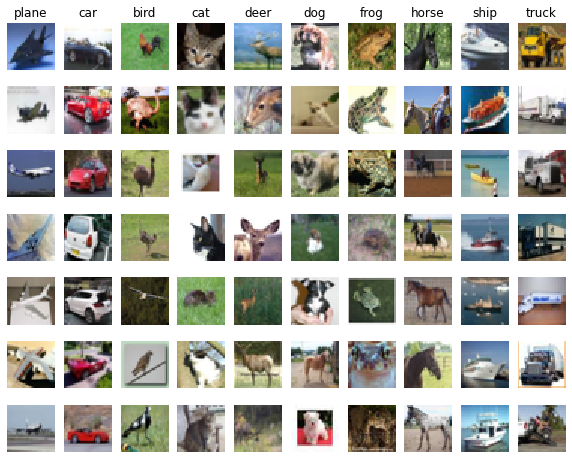

In [5]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [6]:
# Split the data into train, val, and test sets. 
# Check the get_CIFAR10_data function for more details
data = get_CIFAR10_data(cifar10_dir)
for k, v in list(data.items()):
    print(('%s: ' % k, v.shape))

('X_train: ', (49000, 3, 32, 32))
('y_train: ', (49000,))
('X_val: ', (1000, 3, 32, 32))
('y_val: ', (1000,))
('X_test: ', (1000, 3, 32, 32))
('y_test: ', (1000,))


Fully-connected neural networks 

Linear and non-linear layers

<font size='4' color='red'>**Affine layer: foward pass (no for loops)**

In [7]:
def affine_forward(x, w, b):
    """
    Computes the forward pass for an affine (fully-connected) layer.

    The input x has shape (N, d_1, ..., d_k) and contains a minibatch of N
    examples, where each example x[i] has shape (d_1, ..., d_k). We will
    reshape each input into a vector of dimension D = d_1 * ... * d_k, and
    then transform it to an output vector of dimension M.

    Inputs:
    - x: A numpy array containing input data, of shape (N, d_1, ..., d_k)
    - w: A numpy array of weights, of shape (D, M)
    - b: A numpy array of biases, of shape (M,)

    Returns a tuple of:
    - out: output, of shape (N, M)
    - cache: (x, w, b)
    """
    out = None
    ###########################################################################
    # TODO: Implement the affine forward pass. Store the result in out. You   #
    # will need to reshape the input into rows.                               #
    ###########################################################################
    
    # reshaping x
    N = x.shape[0]
    featureSize = np.prod(x.shape[1:])
    X = x.reshape(N,featureSize)
    
    # feature * weights + bias = output
    out = np.matmul(X,w) + b
    
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    cache = (x, w, b)
    return out, cache

<font size='4' color='red'>**Affine layer: backward pass (no for loops).**


In [9]:
def affine_backward(dout, cache):
    """
    Computes the backward pass for an affine layer.

    Inputs:
    - dout: Upstream derivative, of shape (N, M)
    - cache: Tuple of:
      - x: Input data, of shape (N, d_1, ... d_k)
      - w: Weights, of shape (D, M)
      - b: Biases, of shape (M,)

    Returns a tuple of:
    - dx: Gradient with respect to x, of shape (N, d1, ..., d_k)
    - dw: Gradient with respect to w, of shape (D, M)
    - db: Gradient with respect to b, of shape (M,)
    """
    x, w, b = cache
    dx, dw, db = None, None, None
    ###########################################################################
    # TODO: Implement the affine backward pass.                               #
    ###########################################################################
    
    # out = x*w + b
    # dout/dx = w
    # chainrule: dloss/dx = dloss/dout * dout/dx
    dx = np.matmul(dout,np.transpose(w))
    # reshaping to x
    dx = dx.reshape(x.shape)
    
    # dloss/dw = dloss/dout * dout/dw
    # dout/dw = x
    N = x.shape[0]
    featureSize = np.prod(x.shape[1:])
    dw = np.matmul(np.transpose(x.reshape(N,featureSize)),dout)
    
    # dloss/db = dloss/dout * dout/db
    # dout/db = 1
    db = np.sum(dout, axis = 0, keepdims=True)

    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return dx, dw, db

<font size='4' color='red'>**ReLU activation: forward pass (no for loops).**
    


In [11]:
def relu_forward(x):
    """
    Computes the forward pass for a layer of rectified linear units (ReLUs).

    Input:
    - x: Inputs, of any shape

    Returns a tuple of:
    - out: Output, of the same shape as x
    - cache: x
    """
    out = None
    ###########################################################################
    # TODO: Implement the ReLU forward pass.                                  #
    ###########################################################################
    
    # ReLU, y = max(0,x)
    out = np.maximum(0,x)
    
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    cache = x
    return out, cache

<font size='4' color='red'>**ReLU activation: backward pass (no for loops).**
    


In [13]:
def relu_backward(dout, cache):
    """
    Computes the backward pass for a layer of rectified linear units (ReLUs).

    Input:
    - dout: Upstream derivatives, of any shape
    - cache: Input x, of same shape as dout

    Returns:
    - dx: Gradient with respect to x
    """
    dxx, x = dout.copy(), cache
    ###########################################################################
    # TODO: Implement the ReLU backward pass.                                 #
    ###########################################################################
    
    # Values greater than 0 are output as it is, rest turn into 0s
    dx = np.where(x <= 0, 0, dxx)

    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return dx

<font size='4' color='red'>**Softmax loss layer (no for loops).**

In [15]:
def softmax_loss(x, y):
    """
    Computes the loss and gradient for softmax classification.

    Inputs:
    - x: Input data, of shape (N, C) where x[i, j] is the score for the jth
      class for the ith input.
    - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
      0 <= y[i] < C

    Returns a tuple of:
    - loss: Scalar giving the loss
    - dx: Gradient of the loss with respect to x
    """

    ###########################################################################
    # TODO: Implement the softmax_loss function,                              #
    # including the forward and backward passes.                              #
    ###########################################################################
    
    #Getting softmax probs
    softmaxDenom = np.sum(np.exp(x), axis=1).reshape((x.shape[0],1))
    softmaxNum = np.exp(x)
    smProb = np.divide(softmaxNum,softmaxDenom)
    #We take all the indexes of the label using the following method
    NumOfClasses = x.shape[1]
    LabelSize = y.shape[0]
    Vect10 = np.arange(0,(LabelSize*NumOfClasses),NumOfClasses)
    LabelIndex = y + Vect10
    #Getting the loss vector
    VectorProb = smProb.flatten()
    LabelVectorProb = VectorProb[LabelIndex]
    LossVector = -np.log(LabelVectorProb)
    loss = np.average(LossVector)
    
    #Softmax gradient
    smProb[range(y.shape[0]),y] -= 1
    dx = smProb/y.shape[0]
    
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    
    return loss, dx

### Fully-Connected Neural Networks

<font size='4' color='red'>**Two-layer network (no for loops)**
    

In [17]:
class TwoLayerNet(object):
    """
    A two-layer fully-connected neural network with ReLU nonlinearity and
    softmax loss that uses a modular layer design. We assume an input dimension
    of D, a hidden dimension of H, and perform classification over C classes.

    The architecure should be affine - relu - affine - softmax.

    Note that this class does not implement gradient descent; instead, it
    will interact with a separate Solver object that is responsible for running
    optimization.

    The learnable parameters of the model are stored in the dictionary
    self.params that maps parameter names to numpy arrays.
    """

    def __init__(self, input_dim=3*32*32, hidden_dim=100, num_classes=10,
                 weight_scale=1e-3, reg=0.0):
        """
        Initialize a new network.

        Inputs:
        - input_dim: An integer giving the size of the input
        - hidden_dim: An integer giving the size of the hidden layer
        - num_classes: An integer giving the number of classes to classify
        - weight_scale: Scalar giving the standard deviation for random
          initialization of the weights.
        - reg: Scalar giving L2 regularization strength.
        """
        self.params = {}
        self.reg = reg

        ############################################################################
        # TODO: Initialize the weights and biases of the two-layer net. Weights    #
        # should be initialized from a Gaussian centered at 0.0 with               #
        # standard deviation equal to weight_scale, and biases should be           #
        # initialized to zero. All weights and biases should be stored in the      #
        # dictionary self.params, with first layer weights                         #
        # and biases using the keys 'W1' and 'b1' and second layer                 #
        # weights and biases using the keys 'W2' and 'b2'.                         #
        ############################################################################
        
        #initiating a dictionary to hold the cache
        self.cache = {}
        
        output_dim = num_classes
        
        #create a gaussian normal distribution randomizer for initiating weights
        self.params['W1'] = np.random.normal(0.0, weight_scale, size = (input_dim, hidden_dim))
        self.params['W2'] = np.random.normal(0.0, weight_scale, size = (hidden_dim, output_dim))
        self.params['b1'] = np.zeros((1,hidden_dim))
        self.params['b2'] = np.zeros((1,output_dim))
    
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################


    def loss(self, X, y=None):
        """
        Compute loss and gradient for a minibatch of data.

        Inputs:
        - X: Array of input data of shape (N, d_1, ..., d_k)
        - y: Array of labels, of shape (N,). y[i] gives the label for X[i].

        Returns:
        If y is None, then run a test-time forward pass of the model and return:
        - scores: Array of shape (N, C) giving classification scores, where
          scores[i, c] is the classification score for X[i] and class c.

        If y is not None, then run a training-time forward and backward pass and
        return a tuple of:
        - loss: Scalar value giving the loss
        - grads: Dictionary with the same keys as self.params, mapping parameter
          names to gradients of the loss with respect to those parameters.
        """
        scores = None
        ############################################################################
        # TODO: Implement the forward pass for the two-layer net, computing the    #
        # class scores for X and storing them in the scores variable.              #
        ############################################################################
        
        #affine -> relu -> affine:scores
        hidden, self.cache['hidden'] = affine_forward(X, self.params['W1'], self.params['b1'])
        relu, self.cache['relu'] = relu_forward(hidden)
        scores, self.cache['output'] = affine_forward(relu, self.params['W2'], self.params['b2'])

        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        # If y is None then we are in test mode so just return scores
        if y is None:
            return scores

        loss, grads = 0, {}
        ############################################################################
        # TODO: Implement the backward pass for the two-layer net. Store the loss  #
        # in the loss variable and gradients in the grads dictionary. Compute data #
        # loss using softmax, and make sure that grads[k] holds the gradients for  #
        # self.params[k]. Don't forget to add L2 regularization!                   #
        #                                                                          #
        # NOTE: To ensure that your implementation matches ours and you pass the   #
        # automated tests, make sure that your L2 regularization includes a factor #
        # of 0.5 to simplify the expression for the gradient.                      #
        ############################################################################
        
        #L2 regularization parameter and loss
        sumSqWeights = np.sum((self.params['W1'])**2) + np.sum((self.params['W2'])**2)
        loss = softmax_loss(scores, y)[0] + (0.5 * self.reg * (sumSqWeights))

        #Gradients
        upstreamDx, grads['W2'], grads['b2'] = affine_backward(softmax_loss(scores, y)[1], self.cache['output'])
        reluDx = relu_backward(upstreamDx, self.cache['relu'])
        Dx, grads['W1'], grads['b1'] = affine_backward(reluDx, self.cache['hidden'])
        #regularizing gradients
        grads['W1'] = grads['W1'] + self.reg * self.params['W1']
        grads['W2'] = grads['W2'] + self.reg * self.params['W2']
    
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        return loss, grads

<font size='4' color='red'>**Solver.**
    


In [19]:
from utils.solver import Solver

model = TwoLayerNet()
solver = Solver(model, data, update_rule='sgd',optim_config={'learning_rate': 1e-3,},lr_decay=0.93,num_epochs=20, batch_size=100,print_every=100)

##############################################################################
# TODO: Use a Solver instance to train a TwoLayerNet that achieves at least  #
# 50% accuracy on the validation set.                                        #
##############################################################################

solver.train()

##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

(Iteration 1 / 9800) loss: 2.303352
(Epoch 0 / 20) train acc: 0.155000; val_acc: 0.138000
(Iteration 101 / 9800) loss: 1.946860
(Iteration 201 / 9800) loss: 1.682013
(Iteration 301 / 9800) loss: 1.529518
(Iteration 401 / 9800) loss: 1.563434
(Epoch 1 / 20) train acc: 0.440000; val_acc: 0.428000
(Iteration 501 / 9800) loss: 1.602389
(Iteration 601 / 9800) loss: 1.542670
(Iteration 701 / 9800) loss: 1.446672
(Iteration 801 / 9800) loss: 1.438970
(Iteration 901 / 9800) loss: 1.455216
(Epoch 2 / 20) train acc: 0.501000; val_acc: 0.456000
(Iteration 1001 / 9800) loss: 1.258291
(Iteration 1101 / 9800) loss: 1.334780
(Iteration 1201 / 9800) loss: 1.531731
(Iteration 1301 / 9800) loss: 1.464834
(Iteration 1401 / 9800) loss: 1.438507
(Epoch 3 / 20) train acc: 0.512000; val_acc: 0.466000
(Iteration 1501 / 9800) loss: 1.323575
(Iteration 1601 / 9800) loss: 1.335838
(Iteration 1701 / 9800) loss: 1.301038
(Iteration 1801 / 9800) loss: 1.355959
(Iteration 1901 / 9800) loss: 1.237297
(Epoch 4 / 20) t

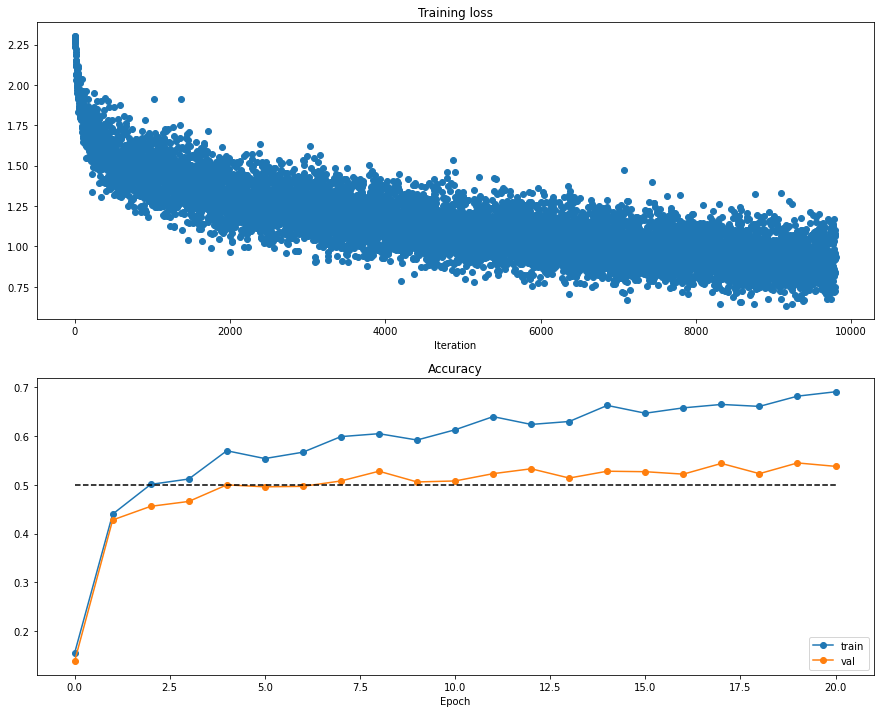

In [20]:
# Run this cell to visualize training loss and train / val accuracy
plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

<font size='4' color='red'>**Multilayer network.**
    


In [21]:
class FullyConnectedNet(object):
    """
    A fully-connected neural network with an arbitrary number of hidden layers,
    ReLU nonlinearities, and a softmax loss function. For a network with L layers,
    the architecture will be

    {affine - relu} x (L - 1) - affine - softmax

    where batch/layer normalization and dropout are optional, and the {...} block is
    repeated L - 1 times.

    Similar to the TwoLayerNet above, learnable parameters are stored in the
    self.params dictionary and will be learned using the Solver class.
    """

    def __init__(self, hidden_dims, input_dim=3*32*32, num_classes=10, reg=0.0,
                 weight_scale=1e-2, dtype=np.float32, seed=None):
        """
        Initialize a new FullyConnectedNet.

        Inputs:
        - hidden_dims: A list of integers giving the size of each hidden layer.
        - input_dim: An integer giving the size of the input.
        - num_classes: An integer giving the number of classes to classify.
        - reg: Scalar giving L2 regularization strength.
        - weight_scale: Scalar giving the standard deviation for random
          initialization of the weights.
        - dtype: A numpy datatype object; all computations will be performed using
          this datatype. float32 is faster but less accurate, so you should use
          float64 for numeric gradient checking.
        - seed: If not None, then pass this random seed to the dropout layers. This
          will make the dropout layers deteriminstic so we can gradient check the
          model.
        """
        self.reg = reg
        self.num_layers = 1 + len(hidden_dims)
        self.dtype = dtype
        self.params = {}

        ############################################################################
        # TODO: Initialize the parameters of the network, storing all values in    #
        # the self.params dictionary. Store weights and biases for the first layer #
        # in W1 and b1; for the second layer use W2 and b2, etc. Weights should be #
        # initialized from a normal distribution centered at 0 with standard       #
        # deviation equal to weight_scale. Biases should be initialized to zero.   #
        ############################################################################
        
        self.cache = {}
        
        for layerIter in range(self.num_layers):
            layer = layerIter + 1
            
            weightKey = 'W' + str(layer)
            biasKey = 'b' + str(layer)
            
            if layer == 1:
                self.params[weightKey] = np.random.normal(0.0, weight_scale, size = (input_dim, hidden_dims[0]))
                self.params[biasKey] = np.zeros((1,hidden_dims[0]))
            elif layer == self.num_layers:
                self.params[weightKey] = np.random.normal(0.0, weight_scale, size = (hidden_dims[-1], num_classes))
                self.params[biasKey] = np.zeros((1,num_classes))
            else:
                self.params[weightKey] = np.random.normal(0.0, weight_scale, size = (hidden_dims[layer-2], hidden_dims[layer-1]))
                self.params[biasKey] = np.zeros((1,hidden_dims[layer-1]))
    
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        # Cast all parameters to the correct datatype
        for k, v in self.params.items():
            self.params[k] = v.astype(dtype)


    def loss(self, X, y=None):
        """
        Compute loss and gradient for the fully-connected net.

        Input / output: Same as TwoLayerNet above.
        """
        X = X.astype(self.dtype)
        mode = 'test' if y is None else 'train'

        scores = None
        ############################################################################
        # TODO: Implement the forward pass for the fully-connected net, computing  #
        # the class scores for X and storing them in the scores variable.          #
        ############################################################################
        
        inputX = X
        for layerIter in range(self.num_layers):
            layer = layerIter + 1
            
            weightKey = 'W' + str(layer)
            biasKey = 'b' + str(layer)
            cacheKey = 'hidden' + str(layer)
            reluKey = 'relu' + str(layer)
            
            if layer != self.num_layers:
                hidden, self.cache[cacheKey] = affine_forward(inputX, self.params[weightKey], self.params[biasKey])
                relu, self.cache[reluKey] = relu_forward(hidden)
                inputX = relu.copy()
            elif layer == self.num_layers:
                scores, self.cache['output'] = affine_forward(inputX, self.params[weightKey], self.params[biasKey])    
    
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        # If test mode return early
        if mode == 'test':
            return scores

        loss, grads = 0.0, {}
        ############################################################################
        # TODO: Implement the backward pass for the fully-connected net. Store the #
        # loss in the loss variable and gradients in the grads dictionary. Compute #
        # data loss using softmax, and make sure that grads[k] holds the gradients #
        # for self.params[k]. Don't forget to add L2 regularization!               #
        #                                                                          #
        # NOTE: To ensure that your implementation matches ours and you pass the   #
        # automated tests, make sure that your L2 regularization includes a factor #
        # of 0.5 to simplify the expression for the gradient.                      #
        ############################################################################
        
        IterList = reversed(list(range(self.num_layers)))
        
        for layerIter in IterList:
            layer = layerIter + 1
            
            weightKey = 'W' + str(layer)
            biasKey = 'b' + str(layer)
            cacheKey = 'hidden' + str(layer)
            reluKey = 'relu' + str(layer)
            
            if layer == self.num_layers:
                loss = softmax_loss(scores,y)[0] + (self.reg * 0.5 * np.sum((self.params[weightKey])**2))
                upstreamDx, grads[weightKey], grads[biasKey] = affine_backward(softmax_loss(scores, y)[1],self.cache['output'])
                grads[weightKey] = grads[weightKey] + self.reg * self.params[weightKey]
                dx = upstreamDx
            else:
                loss = loss + (0.5 * self.reg * np.sum((self.params[weightKey])**2))
                reludx = relu_backward(dx, self.cache[reluKey])
                dx, grads[weightKey], grads[biasKey] = affine_backward(reludx, self.cache[cacheKey])
                grads[weightKey] = grads[weightKey] + self.reg * self.params[weightKey]
    
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        return loss, grads


In [22]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
    print('Running check with reg = ', reg)
    model = FullyConnectedNet(
        [H1, H2], 
        input_dim=D, 
        num_classes=C,
        reg=reg, 
        weight_scale=5e-2, 
        dtype=np.float64
    )

    loss, grads = model.loss(X, y)
    print('Initial loss: ', loss)
  
    # Most of the errors should be on the order of 1e-7 or smaller.   
    # NOTE: It is fine however to see an error for W2 on the order of 1e-5
    # for the check when reg = 0.0
    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
        print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Running check with reg =  0
Initial loss:  2.3004790897684924
W1 relative error: 7.70e-08
W2 relative error: 1.71e-05
W3 relative error: 2.95e-07
b1 relative error: 4.66e-09
b2 relative error: 2.09e-09
b3 relative error: 6.60e-11
Running check with reg =  3.14
Initial loss:  7.052114776533016
W1 relative error: 7.36e-09
W2 relative error: 6.87e-08
W3 relative error: 3.48e-08
b1 relative error: 1.17e-08
b2 relative error: 1.72e-09
b3 relative error: 2.87e-10


<font size='4' color='red'>**Overfitting a small dataset.**



(Iteration 1 / 40) loss: 2.363364
(Epoch 0 / 20) train acc: 0.180000; val_acc: 0.108000
(Epoch 1 / 20) train acc: 0.320000; val_acc: 0.127000
(Epoch 2 / 20) train acc: 0.440000; val_acc: 0.172000
(Epoch 3 / 20) train acc: 0.500000; val_acc: 0.184000
(Epoch 4 / 20) train acc: 0.540000; val_acc: 0.181000
(Epoch 5 / 20) train acc: 0.740000; val_acc: 0.190000
(Iteration 11 / 40) loss: 0.839976
(Epoch 6 / 20) train acc: 0.740000; val_acc: 0.187000
(Epoch 7 / 20) train acc: 0.740000; val_acc: 0.183000
(Epoch 8 / 20) train acc: 0.820000; val_acc: 0.177000
(Epoch 9 / 20) train acc: 0.860000; val_acc: 0.200000
(Epoch 10 / 20) train acc: 0.920000; val_acc: 0.191000
(Iteration 21 / 40) loss: 0.337174
(Epoch 11 / 20) train acc: 0.960000; val_acc: 0.189000
(Epoch 12 / 20) train acc: 0.940000; val_acc: 0.180000
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.199000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.199000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.195000
(Iteration 31 / 40) loss: 

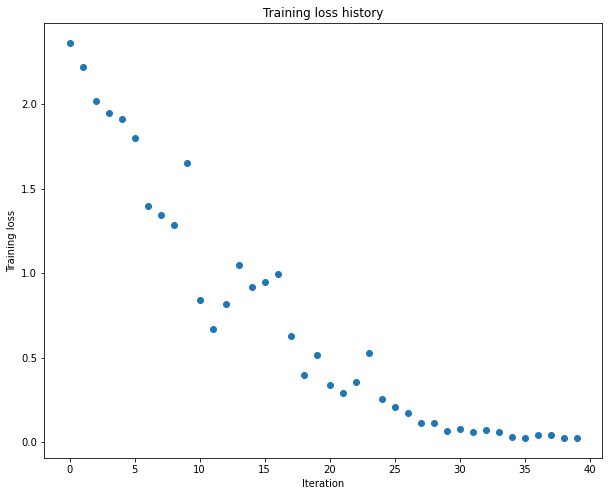

In [23]:
num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}


#############################################################
# tweaking just the learning rate and initialization scale.
#############################################################

weight_scale = 0.01
learning_rate = 0.01

#############################################################
#                 end of your tweaking                      #
#############################################################

model = FullyConnectedNet(
    [100, 100],
    weight_scale=weight_scale, 
    dtype=np.float64

)
solver = Solver(
    model, small_data,
    print_every=10, num_epochs=20, batch_size=25,
    update_rule='sgd',
    optim_config={'learning_rate': learning_rate,}
)
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

<font size='4' color='red'>**Overfitting a small dataset with a five-layer network.**
    


(Iteration 1 / 40) loss: 13.054907
(Epoch 0 / 20) train acc: 0.080000; val_acc: 0.097000
(Epoch 1 / 20) train acc: 0.320000; val_acc: 0.113000
(Epoch 2 / 20) train acc: 0.180000; val_acc: 0.107000
(Epoch 3 / 20) train acc: 0.420000; val_acc: 0.112000
(Epoch 4 / 20) train acc: 0.660000; val_acc: 0.119000
(Epoch 5 / 20) train acc: 0.760000; val_acc: 0.134000
(Iteration 11 / 40) loss: 1.205729
(Epoch 6 / 20) train acc: 0.860000; val_acc: 0.131000
(Epoch 7 / 20) train acc: 0.940000; val_acc: 0.137000
(Epoch 8 / 20) train acc: 0.960000; val_acc: 0.121000
(Epoch 9 / 20) train acc: 0.940000; val_acc: 0.118000
(Epoch 10 / 20) train acc: 0.940000; val_acc: 0.122000
(Iteration 21 / 40) loss: 0.190784
(Epoch 11 / 20) train acc: 0.980000; val_acc: 0.121000
(Epoch 12 / 20) train acc: 0.980000; val_acc: 0.121000
(Epoch 13 / 20) train acc: 0.980000; val_acc: 0.121000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.124000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.125000
(Iteration 31 / 40) loss:

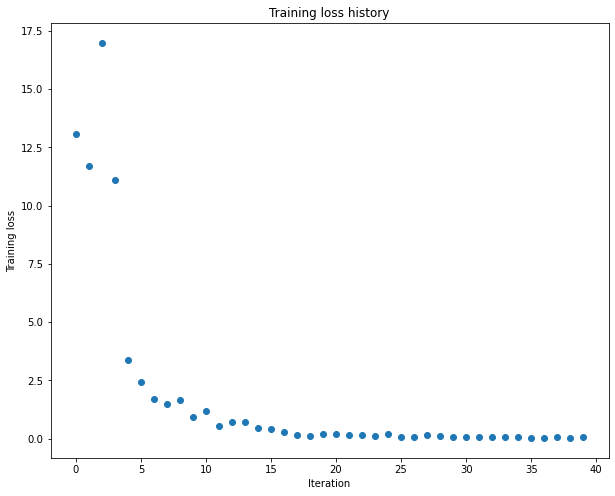

In [24]:
num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}


#############################################################
# tweaking just the learning rate and initialization scale.
#############################################################

weight_scale = 0.06
learning_rate = 0.01

#############################################################
#                 end of your tweaking                      #
#############################################################

model = FullyConnectedNet(
    [100, 100, 100, 100],
    weight_scale=weight_scale, 
    dtype=np.float64
)

solver = Solver(
    model, small_data,
    print_every=10, num_epochs=20, batch_size=25,
    update_rule='sgd',
    optim_config={'learning_rate': learning_rate,}
)
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

<font size='4' color='red'>**SGD+Momentum**
    


In [25]:
def sgd_momentum(w, dw, config=None):
    """
    Performs stochastic gradient descent with momentum.

    config format:
    - learning_rate: Scalar learning rate.
    - momentum: Scalar between 0 and 1 giving the momentum value.
      Setting momentum = 0 reduces to sgd.
    - velocity: A numpy array of the same shape as w and dw used to store a
      moving average of the gradients.
    """
    if config is None: config = {}
    config.setdefault('learning_rate', 1e-2)
    config.setdefault('momentum', 0.9)
    v = config.get('velocity', np.zeros_like(w))

    next_w = None
    ###########################################################################
    # TODO: Implement the momentum update formula. Store the updated value in #
    # the next_w variable. You should also use and update the velocity v.     #
    ###########################################################################
    
    rho = config['momentum']
    vel = v
    learning_rate = config['learning_rate']
    grad_func = dw
    
    v = (rho * vel) - (learning_rate * grad_func)
    next_w = w + v

    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    config['velocity'] = v

    return next_w, config

running with  sgd
(Iteration 1 / 200) loss: 2.559978
(Epoch 0 / 5) train acc: 0.103000; val_acc: 0.108000
(Iteration 11 / 200) loss: 2.291086
(Iteration 21 / 200) loss: 2.153591
(Iteration 31 / 200) loss: 2.082694
(Epoch 1 / 5) train acc: 0.277000; val_acc: 0.242000
(Iteration 41 / 200) loss: 2.004171
(Iteration 51 / 200) loss: 2.010409
(Iteration 61 / 200) loss: 2.024528
(Iteration 71 / 200) loss: 2.024628
(Epoch 2 / 5) train acc: 0.350000; val_acc: 0.308000
(Iteration 81 / 200) loss: 1.804535
(Iteration 91 / 200) loss: 1.917276
(Iteration 101 / 200) loss: 1.923032
(Iteration 111 / 200) loss: 1.707938
(Epoch 3 / 5) train acc: 0.401000; val_acc: 0.321000
(Iteration 121 / 200) loss: 1.704839
(Iteration 131 / 200) loss: 1.766843
(Iteration 141 / 200) loss: 1.788663
(Iteration 151 / 200) loss: 1.828742
(Epoch 4 / 5) train acc: 0.420000; val_acc: 0.320000
(Iteration 161 / 200) loss: 1.628797
(Iteration 171 / 200) loss: 1.902930
(Iteration 181 / 200) loss: 1.541788
(Iteration 191 / 200) los

C:\Users\shaks\anaconda3\envs\cs7150_pa1\lib\site-packages\ipykernel_launcher.py:44: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\shaks\anaconda3\envs\cs7150_pa1\lib\site-packages\ipykernel_launcher.py:47: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\shaks\anaconda3\envs\cs7150_pa1\lib\site-packages\ipykernel_launcher.py:50: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes 

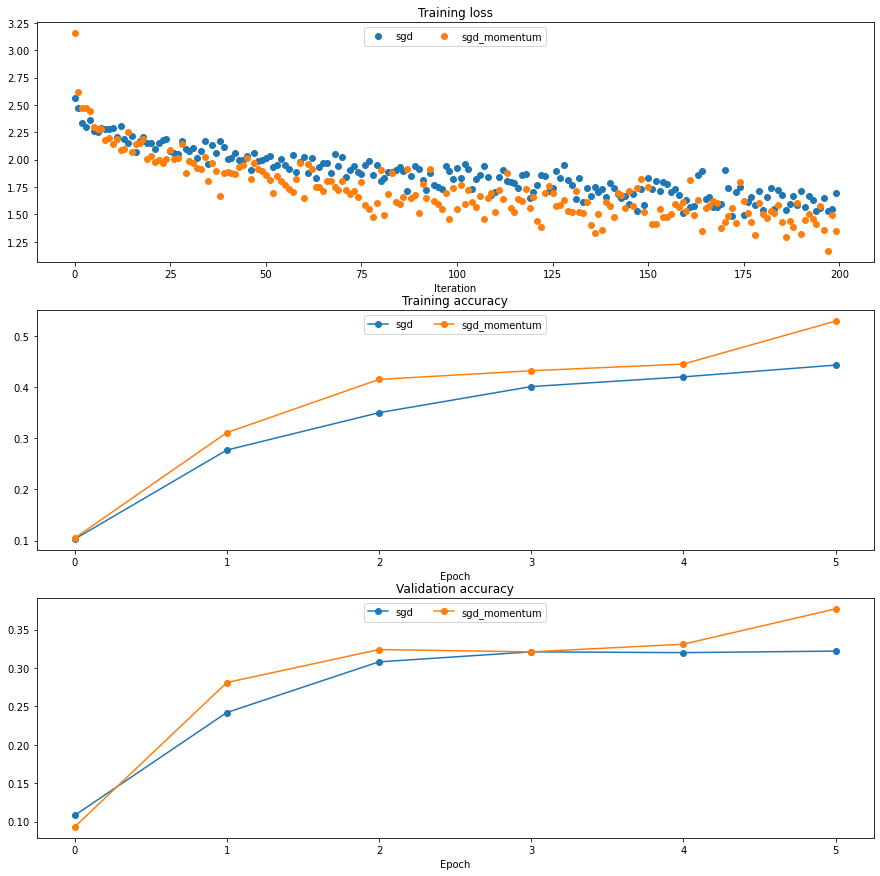

In [27]:
# Run the following to train a six-layer network with both SGD and SGD+momentum. 
# You should see the SGD+momentum update rule converge faster.
from utils.solver import Solver

num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}

for update_rule in ['sgd', 'sgd_momentum']:
    print('running with ', update_rule)
    model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

    solver = Solver(
        model, small_data,
        num_epochs=5, batch_size=100,
        update_rule=update_rule if update_rule == 'sgd' else sgd_momentum,
        optim_config={'learning_rate': 1e-2,},
        verbose=True
    )

    solvers[update_rule] = solver
    solver.train()
    print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in list(solvers.items()):
    plt.subplot(3, 1, 1)
    plt.plot(solver.loss_history, 'o', label=update_rule)

    plt.subplot(3, 1, 2)
    plt.plot(solver.train_acc_history, '-o', label=update_rule)

    plt.subplot(3, 1, 3)
    plt.plot(solver.val_acc_history, '-o', label=update_rule)
  
for i in [1, 2, 3]:
    plt.subplot(3, 1, i)
    plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

<font size='4' color='red'>**Train a good model!**


In [28]:
best_model = None
model = None
################################################################################
# TODO: Train the best FullyConnectedNet that you can on CIFAR-10. You might   #
# find batch/layer normalization and dropout useful. Store your best model in  #
# the best_model variable.                                                     #
################################################################################

data = get_CIFAR10_data(cifar10_dir)

weight = 0.05
learning_rate = 0.005

model = FullyConnectedNet(
    [100,100,100],
    weight_scale=weight, 
    dtype=np.float64,
    reg = 0.02
)
solver = Solver(
    model, data,
    print_every=1000, num_epochs=20, batch_size=50,
    update_rule='sgd',
    optim_config={'learning_rate': learning_rate,},
    lr_decay=0.95
)
solver.train()

################################################################################
#                              END OF YOUR CODE                                #
################################################################################

best_model = model
best_model.params.update(solver.best_params)

(Iteration 1 / 19600) loss: 18.960814
(Epoch 0 / 20) train acc: 0.103000; val_acc: 0.113000
(Epoch 1 / 20) train acc: 0.382000; val_acc: 0.391000
(Iteration 1001 / 19600) loss: 8.402292
(Epoch 2 / 20) train acc: 0.450000; val_acc: 0.408000
(Iteration 2001 / 19600) loss: 7.136704
(Epoch 3 / 20) train acc: 0.442000; val_acc: 0.446000
(Iteration 3001 / 19600) loss: 6.472284
(Epoch 4 / 20) train acc: 0.472000; val_acc: 0.453000
(Iteration 4001 / 19600) loss: 5.441832
(Epoch 5 / 20) train acc: 0.479000; val_acc: 0.451000
(Iteration 5001 / 19600) loss: 4.771593
(Epoch 6 / 20) train acc: 0.529000; val_acc: 0.474000
(Iteration 6001 / 19600) loss: 4.215422
(Epoch 7 / 20) train acc: 0.536000; val_acc: 0.491000
(Iteration 7001 / 19600) loss: 3.781530
(Epoch 8 / 20) train acc: 0.574000; val_acc: 0.484000
(Iteration 8001 / 19600) loss: 3.565448
(Epoch 9 / 20) train acc: 0.555000; val_acc: 0.515000
(Iteration 9001 / 19600) loss: 3.049786
(Epoch 10 / 20) train acc: 0.557000; val_acc: 0.507000
(Iterat

In [29]:
# Run your best model on the validation and test sets. You should achieve above 50% accuracy on the validation set.
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Validation set accuracy:  0.533
Test set accuracy:  0.529
